In [1]:

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# read training and test data from csv files
TRAINING_PATH = "./train.csv"
TESTING_PATH = "./test.csv"

In [3]:

spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()
sc = spark.sparkContext

In [4]:
training_rdd = spark.read.csv(TRAINING_PATH, header=True, inferSchema=True)
testing_rdd = spark.read.csv(TESTING_PATH, header=True, inferSchema=True)

In [5]:
# training_rdd.show(10)
# testing_rdd.show(10)

# print dataset length
print("Training data length: ", training_rdd.count())
print("Testing data length: ", testing_rdd.count())

# print the count of label values in training data
training_rdd.groupBy("label").count().show()
testing_rdd.groupBy("label").count().show()

Training data length:  177041
Testing data length:  58329
+-----+------+
|label| count|
+-----+------+
|    1|101480|
|    0| 75561|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    1|33370|
|    0|24959|
+-----+-----+



In [6]:
# print column data types
training_rdd.printSchema()

root
 |-- URLLength: integer (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- SpacialCharRatioInURL: double (nullable = true)
 |-- LineOfCode: integer (nullable = true)
 |-- LargestLineLength: integer (nullable = true)
 |-- URLTitleMatchScore: double (nullable = true)
 |-- NoOfURLRedirect: integer (nullable = true)
 |-- NoOfSelfRedirect: integer (nullable = true)
 |-- NoOfPopup: integer (nullable = true)
 |-- NoOfiFrame: integer (nullable = true)
 |-- NoOfImage: integer (nullable = true)
 |-- NoOfCSS: integer (nullable = true)
 |-- NoOfJS: integer (nullable = true)
 |-- NoOfSelfRef: integer (nullable = true)
 |-- NoOfEmptyRef: integer (nullable = true)
 |-- NoOfExternalRef: integer 

In [7]:
effective_cols = [
    "URLLength",
    "URLSimilarityIndex",
    "CharContinuationRate",
    "URLCharProb",
    "NoOfSubDomain",
    "DegitRatioInURL",
    "SpacialCharRatioInURL",
    "URLTitleMatchScore",
    "NoOfImage",
    "NoOfJS",
    "IsHTTPS",
    "HasTitle",
    "IsResponsive",
    "HasDescription",
    "HasExternalFormSubmit",
    "HasSocialNet",
    "HasSubmitButton",
    "HasHiddenFields",
    "HasPasswordField",
    "Bank",
    "Pay",
    "Crypto",
    "HasCopyrightInfo"
]

print("Effective columns: ", len(effective_cols))

Effective columns:  23


with cross validation


In [8]:

# Specify the feature columns, excluding the label column
feature_columns = [col for col in training_rdd.columns if col in effective_cols]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")

# Create the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Create a parameter grid for tuning the model's hyperparameters
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [10, 50, 100])
              .addGrid(rf.maxDepth, [5, 10, 15])
              .addGrid(rf.maxBins, [32, 64])
              .build())

# Create a cross-validator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cross_validator = CrossValidator(estimator=rf,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)  # Use 5-fold cross-validation

# Fit the cross-validator to the training data
cv_model = cross_validator.fit(train_df)

# Use the best model to make predictions on the test set
predictions = cv_model.transform(test_df)

# Evaluate the best model using accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

# Evaluate using additional metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Test Precision = {precision:.4f}")

recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Test Recall = {recall:.4f}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score = {f1:.4f}")

# Plot confusion matrix
predictions.groupBy("label", "prediction").count().show()

Test Accuracy = 1.0000
Test Precision = 1.0000
Test Recall = 1.0000
Test F1 Score = 1.0000
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|24957|
|    1|       1.0|33370|
|    0|       1.0|    2|
+-----+----------+-----+



In [13]:

# Create and train the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                            # numTrees=100, maxDepth=4, maxBins=32, seed=42
                            )
rf_model = rf.fit(train_df)

# Make predictions on the test set
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

# show presicion, recall and f1 score
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print(f"Test Precision = {precision:.4f}")

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print(f"Test Recall = {recall:.4f}")

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)

print(f"Test F1 Score = {f1:.4f}")



Test Accuracy = 0.9999
Test Precision = 0.9999
Test Recall = 0.9999
Test F1 Score = 0.9999


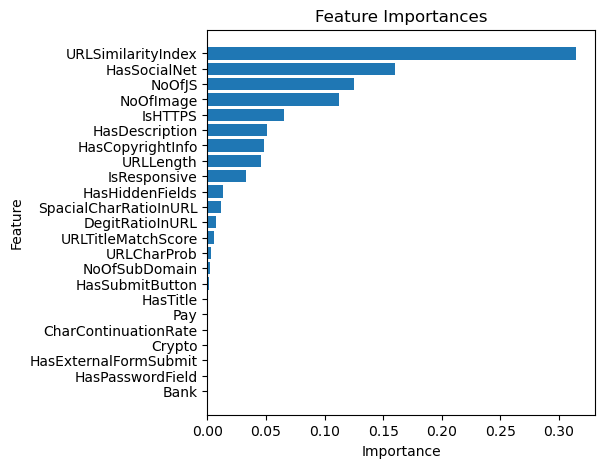

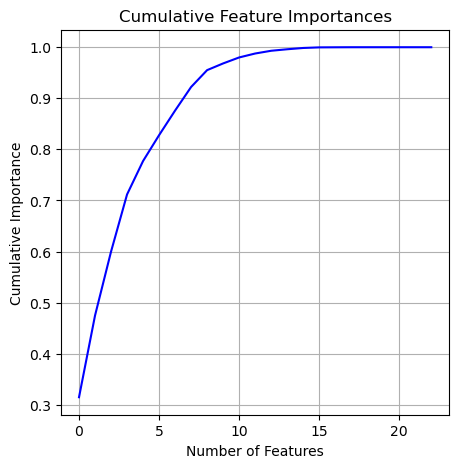

In [14]:
# show most important features in plot

# Retrieve the feature importances from the model as a list
importances = rf_model.featureImportances.toArray()

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = np.array(importances)[indices]
sorted_feature_names = np.array(feature_columns)[indices]


# Create a horizontal bar plot showing the feature importances
plt.figure(figsize=(5,5))
plt.title("Feature Importances")
plt.barh(range(len(importances)), np.array(importances)[indices], align='center')
plt.yticks(range(len(importances)), np.array(feature_columns)[indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()


# show accumulated importance on 
importances = np.array(importances)
indices = np.argsort(importances)[::-1]
importances = importances[indices]
cum_importances = np.cumsum(importances)
plt.figure(figsize=(5,5))
plt.title("Cumulative Feature Importances")
plt.plot(range(len(importances)), cum_importances, 'b-')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.grid(True)
plt.show()

In [15]:
# pick the columns that contribute to 95% of the importance


# Pick the features that contribute up to 95% of importance
threshold = 0.9
num_important_features = np.argmax(cum_importances >= threshold) + 1

# Get the selected feature names
selected_features = sorted_feature_names[:num_important_features]

print(f"Number of features contributing up to {threshold * 100}% importance: {num_important_features}")
print("Selected features:", selected_features)

Number of features contributing up to 90.0% importance: 8
Selected features: ['URLSimilarityIndex' 'HasSocialNet' 'NoOfJS' 'NoOfImage' 'IsHTTPS'
 'HasDescription' 'HasCopyrightInfo' 'URLLength']


In [16]:
feature_columns = [
    col for col in training_rdd.columns if col in selected_features]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# print("Feature columns: ", feature_columns)

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")

train_df.select("features").show(10, truncate=False)
# Create and train the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                            # numTrees=100, maxDepth=4, maxBins=32, seed=42
                            maxDepth=4
                            )
rf_model = rf.fit(train_df)

# Make predictions on the test set
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

# show presicion, recall and f1 score
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print(f"Test Precision = {precision:.4f}")

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print(f"Test Recall = {recall:.4f}")

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)

print(f"Test F1 Score = {f1:.4f}")


+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|(8,[0,1],[19.0,63.08539945])               |
|(8,[0,1],[20.0,66.66666667])               |
|(8,[0,1],[88.0,12.57170048])               |
|(8,[0,1],[22.0,44.48979592])               |
|(8,[0,1],[47.0,22.74695122])               |
|(8,[0,1,2,4],[377.0,2.271881472,1.0,1.0])  |
|[477.0,2.135921472,1.0,0.0,1.0,1.0,0.0,1.0]|
|[427.0,2.237752653,1.0,0.0,1.0,1.0,0.0,1.0]|
|(8,[0,1],[30.0,34.84562067])               |
|(8,[0,1,3],[21.0,38.23129252,1.0])         |
+-------------------------------------------+
only showing top 10 rows

Test Accuracy = 0.9998
Test Precision = 0.9998
Test Recall = 0.9998
Test F1 Score = 0.9998


In [17]:
# write the data with the selected feature columns to csv
training_rdd.select(feature_columns + ["label"]).toPandas().to_csv("train_selected.csv", index=False, header=True)
testing_rdd.select(feature_columns + ["label"]).toPandas().to_csv("test_selected.csv", index=False, header=True)
